In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [2]:
# Import all the libraries for Mask R-CNN
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
import matplotlib.pyplot as plt
import json
import requests
import numpy as np
import argparse
import time
import torch
import torchvision

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_test_loader 
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join

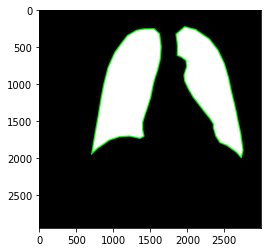

In [3]:
mask1 = cv2.imread(r"/content/gdrive/MyDrive/Kaggle/Lung Segmentation/masks/CHNCXR_0057_0_mask.png")
mask2 = cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY)

contours, hierarchy = cv2.findContours(mask2, cv2.RETR_EXTERNAL,
                                                        cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(mask1, contours, -1, (0,255,0), 15)
plt.imshow(mask1, cmap="gray")

In [ ]:
def get_bboxes(mask):
    """ Pinpoint the coordinates of the masks. 
    
    Parameters
    ----------
    mask : numpy array
        Mask images.
        
    Returns
    ----------
    bboxes : list
        Coordinates of the bboxes.    
    """

    # Find different mask areas.
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    bboxes = []
    
    for contour in contours:
       # Get start and end locations of the bbox.
       start = np.min(contour, axis=0)
       end = np.max(contour, axis=0)
       
       # Concantenate the two array to obtain [x1, y1, x2, y2]
       coors = np.concatenate((start.tolist()[0], end.tolist()[0]))
       
        # Convert coordinates to COCO format.
       coors[2] = coors[2] - coors[0]
       coors[3] = coors[3] - coors[1]
        
       bboxes.append(coors)
        
    return bboxes


def get_segmentations(mask):
       
    contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_EXTERNAL,
                                                        cv2.CHAIN_APPROX_SIMPLE)
    segmentation = []

    for contour in contours:        
        contour = contour.flatten()
        # segmentation.append(contour)
        if len(contour) > 4:
            segmentation.append(contour.astype(float))
    
    return segmentation



def create_COCO_JSON(path, files):
    """Creates annotations from masks in COCO format.  
    Parameters
    ----------
    path : str
        Base path of the masks.
    files : str
        Mask image names.
        
    Returns
    ---------
    new_data : dict
        Annoation content of the all masks in COCO format.
    """
  
    new_data = {"images": [], 
                "categories": [{"id": 0,
                                "name": "chest",
                                "color": "#0ed41a"}], 
                "annotations": []}
    im_id = 0
    anno_id = 0

    for file in files:
        mask = cv2.imread(os.path.join(path, file))
        if file[0] == 'C':
          file = file.split("_mask")[0]+".png"
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        h, w = mask.shape

        tmp_im = {"id": im_id,
                  "file_name": file,
                  "height": h,
                  "width": w,
                 }

        segmentations = get_segmentations(mask)
        bboxes = get_bboxes(mask)
        

        for index in range(len(segmentations)):
          segmentation = segmentations[index].tolist()
          bbox= bboxes[index].tolist()
          tmp_anno = {"id": anno_id, 
                      "image_id": im_id, 
                      "category_id": 0, 
                      "bbox": bbox,
                      "segmentation": [segmentation],
                      "iscrowd": False,
                      "area": (bbox[2]-bbox[0])*(bbox[3]-bbox[1])
                         }
          
        anno_id+= 1

        im_id+= 1

        new_data["images"].append(tmp_im)
        new_data["annotations"].append(tmp_anno)
        
    return new_data


def save_JSON(data, file_name, output_path):    
    file_name += '.json'   
    full_path = os.path.join(output_path, file_name)
    
    try:
        with open(full_path, 'w') as f:
            json.dump(data, f)
        print("JSON created.")
    except IOError as error:
        print(error)


mask = "/content/gdrive/MyDrive/Kaggle/Lung Segmentation/masks"
name_train = "chest_train"
name_val = "chest_val"
output = "/content/gdrive/MyDrive/Kaggle/Lung Segmentation"



files = os.listdir(mask)
train = files[:640]
validation = files [640:]
data_train = create_COCO_JSON(mask, train)
data_val = create_COCO_JSON(mask, validation)


save_JSON(data_train, name_train, output)
save_JSON(data_val, name_val, output)


In [5]:
register_coco_instances("train", {}, "/content/gdrive/MyDrive/Kaggle/Lung Segmentation/chest_train.json", "/content/gdrive/MyDrive/Kaggle/Lung Segmentation/CXR_png")
register_coco_instances("val", {}, "/content/gdrive/MyDrive/Kaggle/Lung Segmentation/chest_val.json", "/content/gdrive/MyDrive/Kaggle/Lung Segmentation/CXR_png")

In [6]:
# Configure and train the model.
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml"))
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_1x.yaml")
#cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_C4_3x/137849458/model_final_280758.pkl"  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.001  # pick a good LR
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.SOLVER.STEPS = []   
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1
#cfg.INPUT.MIN_SIZE_TRAIN = (800,)
cfg.INPUT.MAX_SIZE_TRAIN = 500
cfg.OUTPUT_DIR = "gdrive/MyDrive/Mask_R-CNN_outputs/output/"
cfg.MODEL.DEVICE='cpu'

#os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
#trainer.train()


[01/06 10:30:07 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (2, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

In [7]:
# Inference should use the config with parameters that are used in training
# cfg now already contains everything we've set previously. We changed it a little bit for inference:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

In [ ]:
evaluator = COCOEvaluator("val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

In [9]:
onlyfiles = [f for f in listdir('/content/gdrive/MyDrive/Kaggle/Lung Segmentation/CXR_png') if isfile(join('/content/gdrive/MyDrive/Kaggle/Lung Segmentation/CXR_png', f))]

In [10]:
json_file_path = "/content/gdrive/MyDrive/Kaggle/Lung Segmentation/chest_val.json"

with open(json_file_path, 'r') as j:
  contents = json.loads(j.read())

In [11]:
file_names = [item["file_name"] for item in contents["images"]]

In [12]:
mask_images = []
file_images = []

for images in contents["images"]:
  image = images["file_name"]  
  file_images.append(image)
  
  if image[0] == 'C':
    x=image.split(".")
    mask = "_mask."
    image = x[0]+mask+x[1]

  mask_images.append(image)

In [13]:
def dice_coef(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    
    return (2. * intersection + 1) / (np.sum(y_true_f) + np.sum(y_pred_f) + 1)

In [ ]:
fig = plt.figure(figsize = (7, 7))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)

sum = 0
index = 0

for i in range(len(mask_images)):
  img = cv2.imread(os.path.join("/content/gdrive/MyDrive/Kaggle/Lung Segmentation/CXR_png", file_images[i]))
  predict = predictor(img)

  if len(predict["instances"]) == 0:
    dice_score=0
    print("Dice score of "+ file_images[i] + " = " + str(dice_score))
    index = index - 1
  else:
    mask = cv2.imread(os.path.join("/content/gdrive/MyDrive/Kaggle/Lung Segmentation/masks", mask_images[i]))
    mask = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)   
    mask[mask==255] = 1

    for instance in predict["instances"].pred_masks:
      mask_pred = instance.cpu().detach().numpy().astype('uint8')
      dice_score = dice_coef(mask, mask_pred)
      sum = sum + dice_score
      index = index + 1
  
      print("Dice score of "+ file_images[i] + " = " + str(dice_score))

result = sum / index
print(result)  

In [ ]:
pred_times = []

for image in file_names:
  start = time.time()
  test_image = cv2.imread(os.path.join("/content/gdrive/MyDrive/Kaggle/Lung Segmentation/CXR_png", image))
  outputs = predictor(test_image)
  end = time.time()
  pred_times.append(round(end - start, 3))
  print(str(round(end - start, 3)) + " second.")

In [ ]:
sum = 0
for i in pred_times:
  sum = sum + i
print(sum/64)

In [24]:
test_image = cv2.imread("/content/gdrive/MyDrive/Kaggle/Lung Segmentation/CXR_png/"+file_names[10])
outputs = predictor(test_image)

In [25]:
y_pred = outputs["instances"].pred_masks[0].cpu().detach().numpy().astype('int16')
y_true = cv2.imread("/content/gdrive/MyDrive/Kaggle/Lung Segmentation/masks/CHNCXR_0004_0_mask.png")
y_true = y_true[:,:,0]

In [ ]:
v = Visualizer(test_image[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize=(10, 10))
plt.imshow(out.get_image()[:, :, ::-1])